# Séries temporais com Facebook Prophet e Python

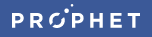

https://facebook.github.io/prophet/  
           
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Este notebook segue o ***Quick Start*** disponível em https://facebook.github.io/prophet/docs/quick_start.html  

## Instalação
As instruções para instalação estão em: https://facebook.github.io/prophet/docs/installation.html#python  
No meu caso utilizei o Anaconda: `conda install -c conda-forge prophet`  
**Atenção:** aparentemente há problemas na instalação em sistemas Windows.

## Origem dos dados
https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1470528000&period2=1628294400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true  
Nesta página é possível baixar um arquivo *csv* com dados históricos do papel selecionado.  
O arquivo baixado vai de 06/08/2016 a 06/08/2021. Preços em Reais.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15,6)
from prophet import Prophet

In [2]:
inicial = pd.read_csv('PETR4.csv')
inicial.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,11.79,11.97,11.70,11.91,10.689182,41552000.0
1,2016-08-09,11.92,12.07,11.75,11.88,10.662257,33596200.0
2,2016-08-10,11.95,11.97,11.56,11.56,10.375061,41638400.0
3,2016-08-11,11.63,12.10,11.60,12.10,10.859708,55881500.0
4,2016-08-12,12.05,12.44,11.98,12.00,10.769958,71281300.0


In [3]:
inicial.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1239,2021-08-02,27.200001,27.410000,26.370001,26.410000,26.410000,70528800.0
1240,2021-08-03,26.360001,26.870001,25.790001,26.850000,26.850000,71850400.0
1241,2021-08-04,26.549999,26.770000,25.950001,26.280001,26.280001,87970600.0
1242,2021-08-05,28.750000,28.980000,28.059999,28.350000,28.350000,223915900.0
1243,2021-08-06,28.500000,28.540001,28.020000,28.389999,28.389999,51106100.0


## Verificação dos tipos de dados
Conforme o *Quick Start*:
> The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [4]:
inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1244 non-null   object 
 1   Open       1240 non-null   float64
 2   High       1240 non-null   float64
 3   Low        1240 non-null   float64
 4   Close      1240 non-null   float64
 5   Adj Close  1240 non-null   float64
 6   Volume     1240 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.2+ KB


Os valores dos preços estão conforme a necessidade para `y`, mas a coluna de data precisa ser adequada.
### Acertando o tipo de dados da coluna `Date`

In [6]:
inicial['Date'] = pd.to_datetime(inicial['Date'])
inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1244 non-null   datetime64[ns]
 1   Open       1240 non-null   float64       
 2   High       1240 non-null   float64       
 3   Low        1240 non-null   float64       
 4   Close      1240 non-null   float64       
 5   Adj Close  1240 non-null   float64       
 6   Volume     1240 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.2 KB


In [7]:
inicial

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,11.790000,11.970000,11.700000,11.910000,10.689182,41552000.0
1,2016-08-09,11.920000,12.070000,11.750000,11.880000,10.662257,33596200.0
2,2016-08-10,11.950000,11.970000,11.560000,11.560000,10.375061,41638400.0
3,2016-08-11,11.630000,12.100000,11.600000,12.100000,10.859708,55881500.0
4,2016-08-12,12.050000,12.440000,11.980000,12.000000,10.769958,71281300.0
...,...,...,...,...,...,...,...
1239,2021-08-02,27.200001,27.410000,26.370001,26.410000,26.410000,70528800.0
1240,2021-08-03,26.360001,26.870001,25.790001,26.850000,26.850000,71850400.0
1241,2021-08-04,26.549999,26.770000,25.950001,26.280001,26.280001,87970600.0
1242,2021-08-05,28.750000,28.980000,28.059999,28.350000,28.350000,223915900.0


### Selecionando as colunas de data e preço de fechamento para o *dataset* `treino`

In [8]:
treino = inicial[['Date','Close']]
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1244 non-null   datetime64[ns]
 1   Close   1240 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.6 KB


In [9]:
treino.head()

,Date,Close
0,2016-08-08,11.91
1,2016-08-09,11.88
2,2016-08-10,11.56
3,2016-08-11,12.10
4,2016-08-12,12.00


### Plotando os dados para verificação

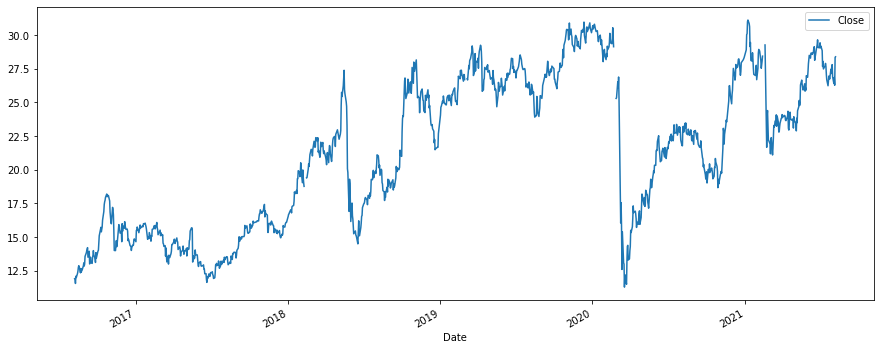

In [10]:
treino_ = treino.copy()
treino_.set_index('Date', inplace=True)
treino_.plot();

### Acertando nomes de colunas para o Prophet

In [11]:
treino.columns = ['ds','y']
treino

,ds,y
0,2016-08-08,11.910000
1,2016-08-09,11.880000
2,2016-08-10,11.560000
3,2016-08-11,12.100000
4,2016-08-12,12.000000
...,...,...
1239,2021-08-02,26.410000
1240,2021-08-03,26.850000
1241,2021-08-04,26.280001
1242,2021-08-05,28.350000


## Criando e *fitando* o modelo no Prophet

In [12]:
modelo = Prophet()
modelo.fit(treino)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Criando o *dataset* para previsão
Conforme o *Quick Start*:  
> Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [13]:
futuro = modelo.make_future_dataframe(periods=365)
futuro.tail()

,ds
1604,2022-08-02
1605,2022-08-03
1606,2022-08-04
1607,2022-08-05
1608,2022-08-06


> The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [14]:
previsao = modelo.predict(futuro)
previsao[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1604,2022-08-02,33.370296,28.543271,38.715826
1605,2022-08-03,33.360890,28.071013,38.191185
1606,2022-08-04,33.292669,28.372784,38.031820
1607,2022-08-05,33.214976,28.219236,38.145387
1608,2022-08-06,31.917073,26.756596,36.774833


## Plotando a previsão
O Prophet tem um método `plot` próprio que mostra:
   - os dados atuais (pontos pretos),  
   - o *fit* do modelo para os dados presentes,  
   - a previsão a partir das datas inseridas com `make_future_dataframe`,  
   - os intervalos de confiança.  

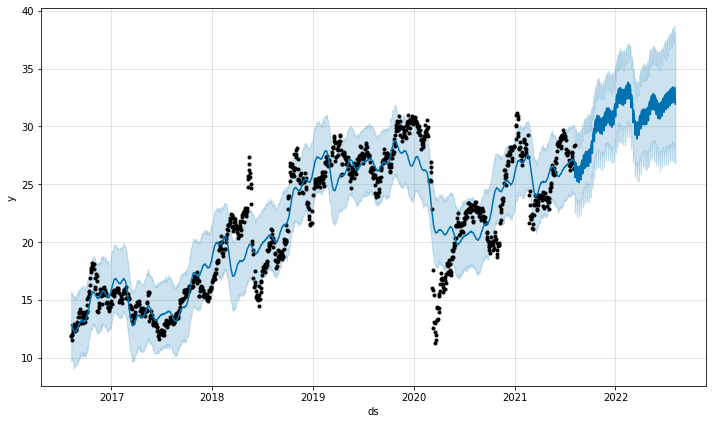

In [15]:
fig1 = modelo.plot(previsao)

O método `plot_components` mostra os componentes da previsão, dividos automaticamente em *trend*, *weekly* e *yearly*.

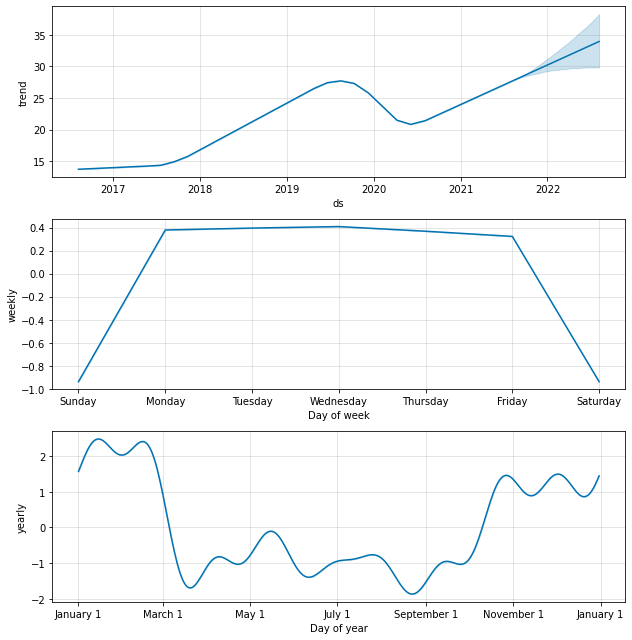

In [16]:
fig2 = modelo.plot_components(previsao)

## Observação
As séries temporais de ativos negociados em Bolsas de Valores geralmente só tem datas em dias úteis, o que precisa ser tratado ao serem analisadas. O Prophet indica na sua documentação que ele trata finais de semana, o que parece acontecer na análise acima. A biblioteca também tem uma forma de tratar feriados.